# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict, plot_acf, plot_pacf

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

### 1b. Load the data
Call the variable `cigData`. 

In [45]:
cigData = pd.read_csv('CowboyCigsData.csv')
cigData['#CigSales'] -= 1000000
cigData['#CigSales'] *= 100000

# Note: I modify the data given Frank Fletcher's notes
# See https://github.com/frankfletcher/Springboard-Data-Science/blob/master/Module%2021.1%20-%20Cowboys%20and%20Cigrettes%20Case%20Study/Cowboy%20Cigarettes%20Case%20Study%20-%20Tier%203-FrankFletcher-better-version.ipynb

# "Frank's Note: "This data was altered to obfuscate the fact that it comes 
# from a well-known data set that has nothing to do with cigarette sales. 
# In fact, the altered version DOES NOT WORK with the exercises given.
# In the next line, I remove the alteration by subtracting 10e5 
# and then alter the data by multiplying by 10e4 
# in order to make a new dataset where the scale is roughly the same 
# but the variance is commensurate to the scale."

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [46]:
cigData

,Unnamed: 0,Time,#CigSales
0,0,1949-01,11200000
1,1,1949-02,11800000
2,2,1949-03,13200000
3,3,1949-04,12900000
4,4,1949-05,12100000
...,...,...,...
139,139,1960-08,60600000
140,140,1960-09,50800000
141,141,1960-10,46100000
142,142,1960-11,39000000


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [47]:
cigData.columns

Index(['Unnamed: 0', 'Time', '#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [48]:
cigData.dtypes

Unnamed: 0     int64
Time          object
#CigSales      int64
dtype: object

Check whether there are any null values. 

In [49]:
cigData.isna().sum()

Unnamed: 0    0
Time          0
#CigSales     0
dtype: int64

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [50]:
cigData.drop(columns=['Unnamed: 0'], inplace=True)

In [51]:
cigData

,Time,#CigSales
0,1949-01,11200000
1,1949-02,11800000
2,1949-03,13200000
3,1949-04,12900000
4,1949-05,12100000
...,...,...
139,1960-08,60600000
140,1960-09,50800000
141,1960-10,46100000
142,1960-11,39000000


### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [52]:
cigData.rename(columns={'Time':'Month'}, inplace=True)

Call a head() to check this has worked. 

In [53]:
cigData.head()

,Month,#CigSales
0,1949-01,11200000
1,1949-02,11800000
2,1949-03,13200000
3,1949-04,12900000
4,1949-05,12100000


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [54]:
cigData['Month'] = pd.to_datetime(cigData['Month'])

In [55]:
cigData.set_index('Month', inplace=True)

In [56]:
type(cigData.index)

pandas.core.indexes.datetimes.DatetimeIndex

Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [57]:
y = cigData['#CigSales']

Check the type of our new variable. 

In [58]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [59]:
y.describe().apply(lambda x: format(x, 'f')) 

count         144.000000
mean     28029861.111111
std      11996631.694294
min      10400000.000000
25%      18000000.000000
50%      26550000.000000
75%      36050000.000000
max      62200000.000000
Name: #CigSales, dtype: object

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

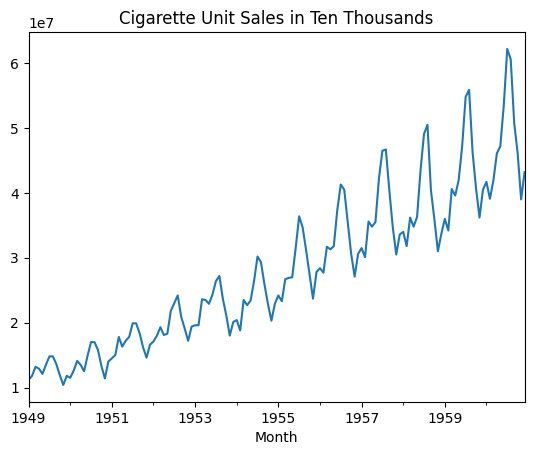

In [60]:
y.plot()

plt.title('Cigarette Unit Sales in Ten Thousands')
plt.show()

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

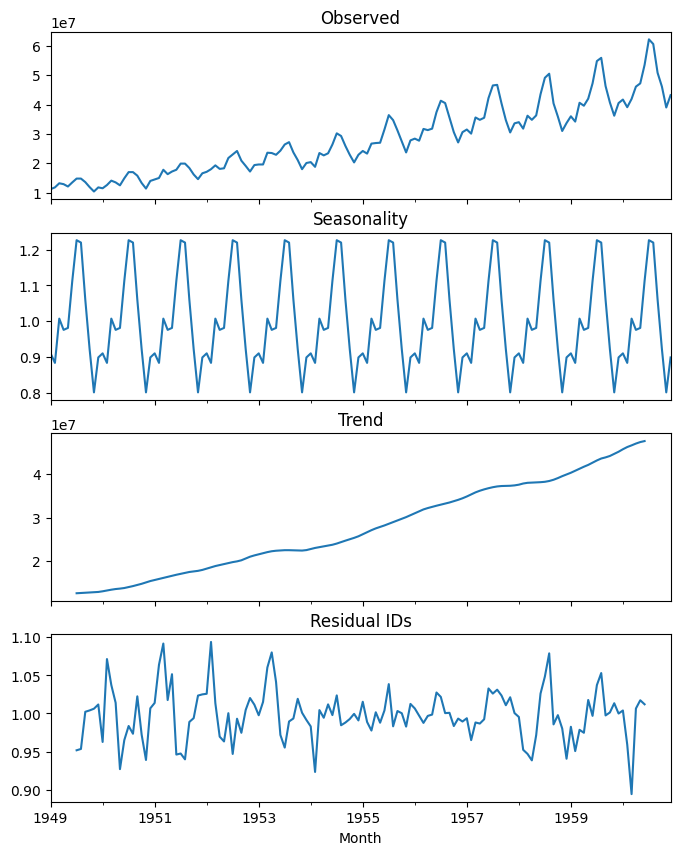

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Plot the original data, the trend, the seasonality, and the residuals 
y_decompose = seasonal_decompose(y, model='multiplicative')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True)
fig.set_size_inches(8, 10, forward=True)

y_decompose.observed.plot(ax=ax1, title='Observed')
y_decompose.seasonal.plot(ax=ax2, title='Seasonality')
y_decompose.trend.plot(ax=ax3, title='Trend')
y_decompose.resid.plot(ax=ax4, title='Residual IDs')

plt.show()

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [20]:
from statsmodels.tsa.stattools import kpss

print('The KPPS Test p-value = ' + str(kpss(y)[1]))

The KPPS Test p-value = 0.01


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

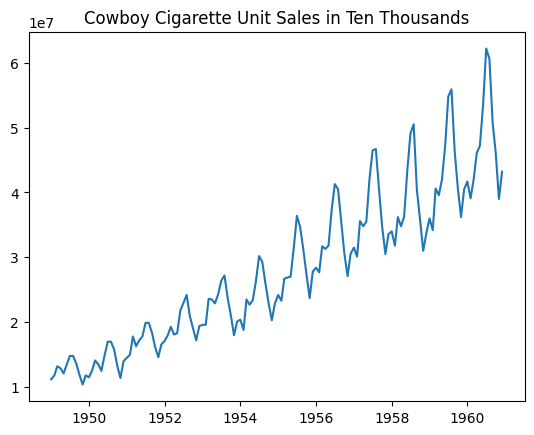

In [21]:
plt.plot(y)
plt.title('Cowboy Cigarette Unit Sales in Ten Thousands')
plt.show()

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [61]:
y_log = np.log(y)


When you plot this, you can see how the variance in our data now remains contant over time.

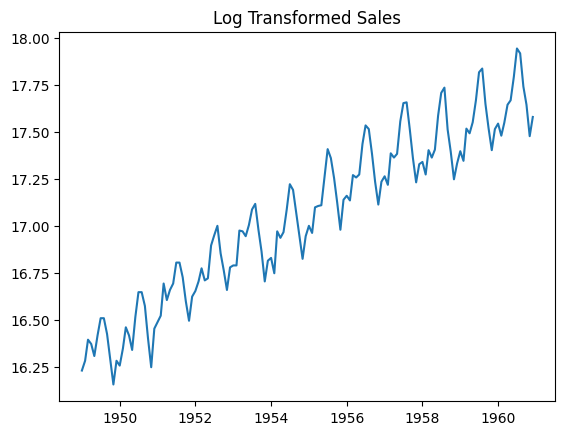

In [62]:
plt.plot(y_log)
plt.title('Log Transformed Sales')
plt.show()


We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [24]:
y_log_diff = y_log.diff().dropna()

In [25]:
print('The KPSS test p-value = ' + str(kpss(y_log_diff)[1]))

The KPSS test p-value = 0.1


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [38]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [39]:
def arima_mse(data, p, d, q):
    
    # split train and test
    train, test = data.iloc[:len(data)-24], data[len(data)-24:]
    
    #define and fit
    model = ARIMA(train, order=(p, d, q))
    model_fit = model.fit()

    #predict
    predictions = model_fit.forecast(len(test))[0]
    
    # mse
    error = mean_squared_error(test, predictions)

    return error

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [40]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:                
                try:
                    mse = arima_mse(dataset, p, d, q)
                    order = (p, d, q)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order, mse))
                except: 
                    warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [41]:
# Now, we choose a couple of values to try for each parameter.
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [191]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
evaluate_models(y_log, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.475
ARIMA(0, 0, 1) MSE=0.469
ARIMA(0, 1, 0) MSE=0.049
ARIMA(0, 1, 1) MSE=0.039
ARIMA(0, 1, 2) MSE=0.030
ARIMA(0, 2, 0) MSE=0.937
ARIMA(0, 2, 1) MSE=0.111
ARIMA(0, 2, 2) MSE=0.087
ARIMA(1, 0, 0) MSE=0.210
ARIMA(1, 0, 1) MSE=0.242
ARIMA(1, 0, 2) MSE=0.175
ARIMA(1, 1, 0) MSE=0.043
ARIMA(1, 1, 1) MSE=0.036
ARIMA(1, 1, 2) MSE=0.027
ARIMA(1, 2, 0) MSE=0.036
ARIMA(2, 0, 0) MSE=0.247
ARIMA(2, 0, 1) MSE=0.210
ARIMA(2, 0, 2) MSE=0.260
ARIMA(2, 1, 0) MSE=0.039
ARIMA(2, 1, 1) MSE=0.030
ARIMA(2, 1, 2) MSE=0.033
ARIMA(2, 2, 0) MSE=0.241
ARIMA(2, 2, 1) MSE=0.084
ARIMA(2, 2, 2) MSE=0.079
Best ARIMA(1, 1, 2) MSE=0.027


So the best p,d, q, parameters for our ARIMA model are 1, 1, 2 respectively. Now we know this, we can build the model.

In [157]:
model_order = (1, 1, 2)
model = ARIMA(y_log, order=model_order)
model_fit = model.fit()
pred = model_fit.predict()[12:]
forecast = model_fit.forecast(24)

In [227]:
pred

1950-01-01    16.356441
1950-02-01    16.234072
1950-03-01    16.395289
1950-04-01    16.450423
1950-05-01    16.379708
                ...    
1960-08-01    17.909150
1960-09-01    17.840022
1960-10-01    17.680147
1960-11-01    17.646088
1960-12-01    17.465913
Freq: MS, Name: predicted_mean, Length: 132, dtype: float64

In [193]:
np.exp(pred).apply(lambda x: format(x, 'f')) 

1950-01-01    12691479.458460
1950-02-01    11229691.686588
1950-03-01    13194209.883378
1950-04-01    13942090.139613
1950-05-01    12990225.538967
                   ...       
1960-08-01    59957730.208029
1960-09-01    55952943.275832
1960-10-01    47685949.018311
1960-11-01    46089134.991484
1960-12-01    38490153.630997
Freq: MS, Name: predicted_mean, Length: 132, dtype: object

We can take a look at a summary of the model this library has built around our data.

In [194]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              #CigSales   No. Observations:                  144
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 128.432
Date:                Wed, 24 May 2023   AIC                           -248.865
Time:                        15:50:02   BIC                           -237.013
Sample:                    01-01-1949   HQIC                          -244.049
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5432      0.134      4.069      0.000       0.282       0.805
ma.L1         -0.3823      0.148     -2.586      0.010      -0.672      -0.093
ma.L2         -0.4096      0.096     -4.266      0.000      -0.598      -0.221
sigma2         0.0097      0.002      5.646      0.000       0.006       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 8.01
Prob(Q):                              0.60   Prob(JB):                         0.02
Heteroskedasticity (H):               1.16   Skew:                             0.03
Prob(H) (two-sided):                  0.61   Kurtosis:                         1.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### student note:
I decided to try a few other ways to find the best model. 

#### 3diii. Plotting the acf/pacf

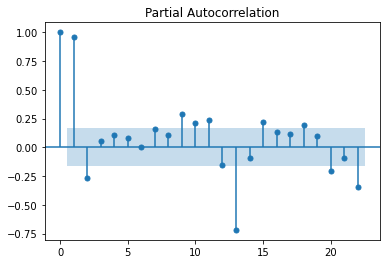

In [239]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# fig, ax = plt.subplots(2, figsize=(8,12))

# plot the ACF
# plot_acf(cigData, ax=ax[0])

# plot the PACF
# plot_pacf(cigData, ax=ax[1])
plot_pacf(cigData)

plt.show()

The partial autocorrelation function would suggest that two lags significantly differ from zero. So we'd want a p=2 value.

#### 3div. Using the AIC/BIC (lower is better)

In [26]:
# Now, we choose a couple of values to try for each parameter.
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [27]:
def akaikeIC(dataset, p_values, d_values, q_values):
    for p in p_values:
        for d in d_values:
                for q in q_values:
                    order=p,d,q
                    mod = ARIMA(dataset, order=(p,d,q))
                    res = mod.fit()
                    print('ARIMA%s AIC=%.3f'%(order, res.aic))

In [28]:
akaikeIC(y_log, p_values, d_values, q_values)

ARIMA(0, 0, 0) AIC=176.160
ARIMA(0, 0, 1) AIC=6.876
ARIMA(0, 0, 2) AIC=-90.158
ARIMA(0, 1, 0) AIC=-232.439
ARIMA(0, 1, 1) AIC=-238.725
ARIMA(0, 1, 2) AIC=-240.847
ARIMA(0, 2, 0) AIC=-164.712
ARIMA(0, 2, 1) AIC=-223.958
ARIMA(0, 2, 2) AIC=-230.328
ARIMA(1, 0, 0) AIC=-228.131
ARIMA(1, 0, 1) AIC=-235.408
ARIMA(1, 0, 2) AIC=-236.295
ARIMA(1, 1, 0) AIC=-236.598
ARIMA(1, 1, 1) AIC=-242.626
ARIMA(1, 1, 2) AIC=-248.865
ARIMA(1, 2, 0) AIC=-175.737
ARIMA(1, 2, 1) AIC=-228.189
ARIMA(1, 2, 2) AIC=-234.212
ARIMA(2, 0, 0) AIC=-233.283
ARIMA(2, 0, 1) AIC=-238.673
ARIMA(2, 0, 2) AIC=-236.989
ARIMA(2, 1, 0) AIC=-238.522
ARIMA(2, 1, 1) AIC=-251.464
ARIMA(2, 1, 2) AIC=-247.780
ARIMA(2, 2, 0) AIC=-186.751
ARIMA(2, 2, 1) AIC=-230.068
ARIMA(2, 2, 2) AIC=-232.353


In [29]:
def bayesianIC(dataset, p_values, d_values, q_values):
    for p in p_values:
        for d in d_values:
                for q in q_values:
                    order=p,d,q
                    mod = ARIMA(dataset, order=(p,d,q))
                    res = mod.fit()
                    print('ARIMA%s BIC=%.3f'%(order, res.bic))

In [30]:
bayesianIC(y_log, p_values, d_values, q_values)

ARIMA(0, 0, 0) BIC=182.100
ARIMA(0, 0, 1) BIC=15.786
ARIMA(0, 0, 2) BIC=-78.279
ARIMA(0, 1, 0) BIC=-229.476
ARIMA(0, 1, 1) BIC=-232.800
ARIMA(0, 1, 2) BIC=-231.958
ARIMA(0, 2, 0) BIC=-161.757
ARIMA(0, 2, 1) BIC=-218.047
ARIMA(0, 2, 2) BIC=-221.461
ARIMA(1, 0, 0) BIC=-219.221
ARIMA(1, 0, 1) BIC=-223.529
ARIMA(1, 0, 2) BIC=-221.446
ARIMA(1, 1, 0) BIC=-230.672
ARIMA(1, 1, 1) BIC=-233.738
ARIMA(1, 1, 2) BIC=-237.013
ARIMA(1, 2, 0) BIC=-169.826
ARIMA(1, 2, 1) BIC=-219.321
ARIMA(1, 2, 2) BIC=-222.388
ARIMA(2, 0, 0) BIC=-221.403
ARIMA(2, 0, 1) BIC=-223.824
ARIMA(2, 0, 2) BIC=-219.170
ARIMA(2, 1, 0) BIC=-229.633
ARIMA(2, 1, 1) BIC=-239.612
ARIMA(2, 1, 2) BIC=-232.965
ARIMA(2, 2, 0) BIC=-177.883
ARIMA(2, 2, 1) BIC=-218.244
ARIMA(2, 2, 2) BIC=-217.573


The lower the AIC/BIC score, the better the goodness of fit. Both the AIC/BIC suggest that the parameters (2,1,1) give the best ARIMA model. The MSE we found earlier suggested (1,1,2) which is a close second.

In [74]:
model2_order = (2,1,1)
model2 = ARIMA(y_log, order=model2_order)
model2_fit = model2.fit()
pred2 = model2_fit.predict()[12:]
forecast2 = model2_fit.forecast(24)

In [75]:
np.exp(pred2).apply(lambda x: format(x, 'f')) 

1950-01-01    12706485.423175
1950-02-01    11617788.760094
1950-03-01    13007213.874011
1950-04-01    14228528.604641
1950-05-01    12957180.944536
                   ...       
1960-08-01    60254134.350472
1960-09-01    55571733.404629
1960-10-01    46499880.507866
1960-11-01    45100099.607496
1960-12-01    38735393.457571
Freq: MS, Name: predicted_mean, Length: 132, dtype: object

We can take a look at a summary of the model this library has built around our data.

In [33]:
model2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              #CigSales   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 129.732
Date:                Wed, 24 May 2023   AIC                           -251.464
Time:                        20:51:37   BIC                           -239.612
Sample:                    01-01-1949   HQIC                          -246.648
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9792      0.100      9.839      0.000       0.784       1.174
ar.L2         -0.3740      0.118     -3.177      0.001      -0.605      -0.143
ma.L1         -0.8303      0.102     -8.118      0.000      -1.031      -0.630
sigma2         0.0095      0.002      6.134      0.000       0.006       0.013
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):                 8.63
Prob(Q):                              0.31   Prob(JB):                         0.01
Heteroskedasticity (H):               1.14   Skew:                             0.22
Prob(H) (two-sided):                  0.66   Kurtosis:                         1.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


#### 3dv. pmdarima's auto_arima grid search

In [68]:
from pmdarima import auto_arima # for determining ARIMA orders

# train-test-split
train, test = y_log.iloc[:len(y)-24], y[len(y)-24:]

auto_arima(train, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  120
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 201.768
Date:                              Wed, 24 May 2023   AIC                           -393.537
Time:                                      21:07:49   BIC                           -380.126
Sample:                                  01-01-1949   HQIC                          -388.099
                                       - 12-01-1958                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0179      0.010      1.800      0.072      -0.002       0.037
ar.L1          0.6161      0.088      6.966      0.000       0.443       0.789
ar.L2          0.2356      0.092      2.548      0.011       0.054       0.417
ma.S.L12      -0.5561      0.120     -4.624      0.000      -0.792      -0.320
sigma2         0.0013      0.000      7.468      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.48
Prob(Q):                              1.00   Prob(JB):                         0.18
Heteroskedasticity (H):               0.40   Skew:                             0.11
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

pmdarima's auto_arima function recommends a SARIMAX model with p=2, d=0, q=0, ps=0, pd=1, pq=1, period=12. As we can see the AIC and BIC values are significantly better than our ARIMA(2,1,1) model.

In [71]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model3 = SARIMAX(y_log, order=(2,0,0), 
                seasonal_order=(0,1,1,12), freq='MS')
model3_fit = model3.fit()

# predict the future!
pred3 = model3_fit.predict()[12:]
forecast3 = model3_fit.forecast(24)



### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

Here's the second (better) ARIMA model: ARIMA(2,1,1) given using the AIC and BIC.

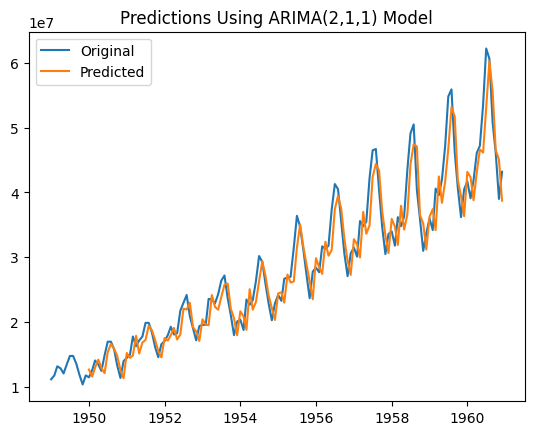

In [77]:
plt.plot(np.exp(y_log), label='Original')
plt.plot(np.exp(model2_fit.predict()[12:]), label='Predicted')

plt.legend()
plt.title('Predictions Using ARIMA(2,1,1) Model')
plt.show()

Now here's the SARIMAX model which had a better AIC and BIC score and takes seasonality into account.

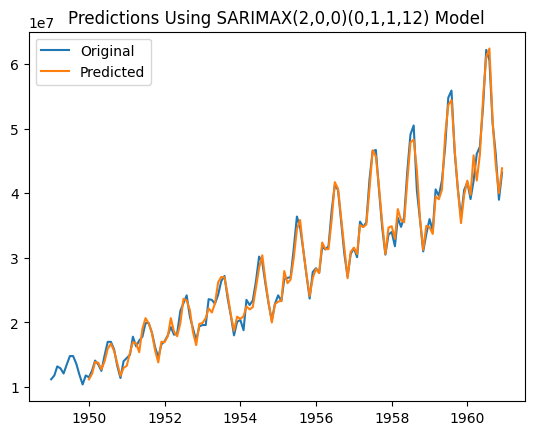

In [73]:
plt.plot(np.exp(y_log), label='Original')
plt.plot(np.exp(model3_fit.predict()[12:]), label='Predicted')

plt.legend()
plt.title('Predictions Using SARIMAX(2,0,0)(0,1,1,12) Model')
plt.show()

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

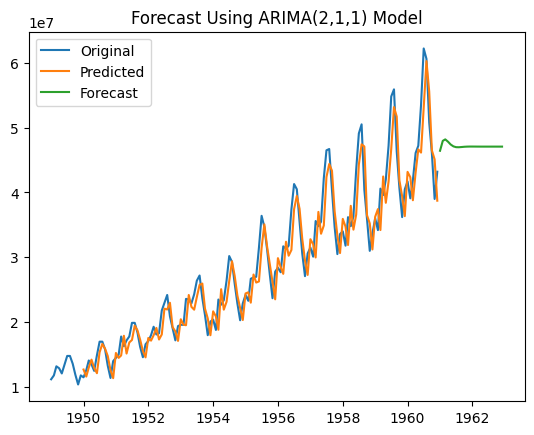

In [81]:
plt.plot(np.exp(y_log), label='Original')
plt.plot(np.exp(model2_fit.predict()[12:]), label='Predicted')
plt.plot(np.exp(forecast2), label='Forecast')

plt.legend()
plt.title('Forecast Using ARIMA(2,1,1) Model')
plt.show()

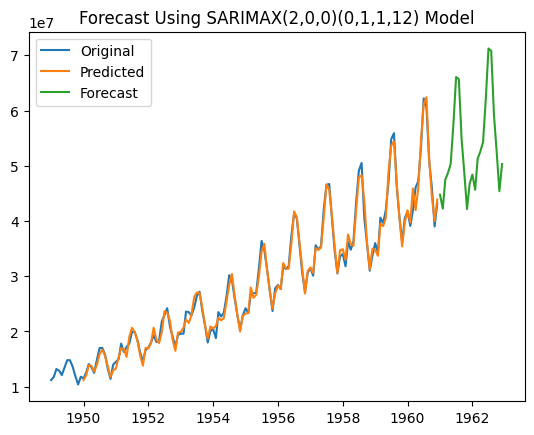

In [83]:
plt.plot(np.exp(y_log), label='Original')
plt.plot(np.exp(model3_fit.predict()[12:]), label='Predicted')
plt.plot(np.exp(forecast3), label='Forecast')

plt.legend()
plt.title('Forecast Using SARIMAX(2,0,0)(0,1,1,12) Model')
plt.show()

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 